In [1]:
!pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
              } # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [3]:
bucket_name = 'xgboost-imd-youngjin' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
try:
  urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
  print('Success: downloaded bank_clean.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('./bank_clean.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:b
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [17]:
model_data.dtypes

age                     int64
campaign                int64
pdays                   int64
previous                int64
no_previous_contact     int64
                        ...  
poutcome_failure        int64
poutcome_nonexistent    int64
poutcome_success        int64
y_no                    int64
y_yes                   int64
Length: 61, dtype: object

In [19]:
model_data.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


age


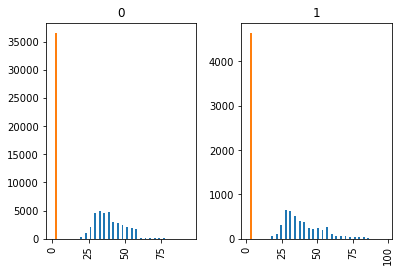

campaign


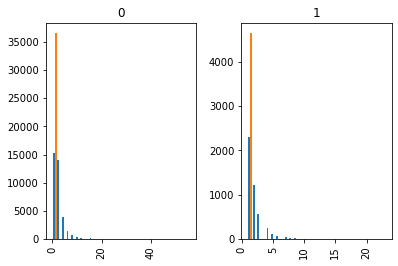

pdays


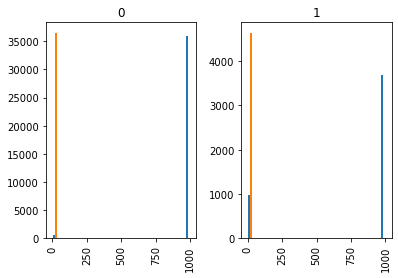

previous


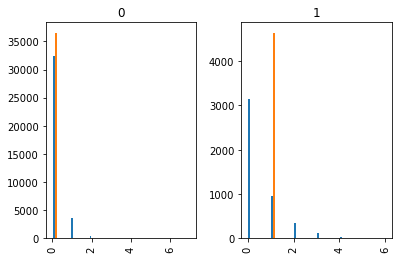

no_previous_contact


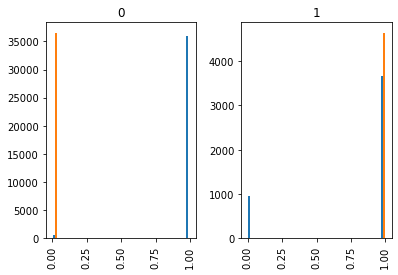

not_working


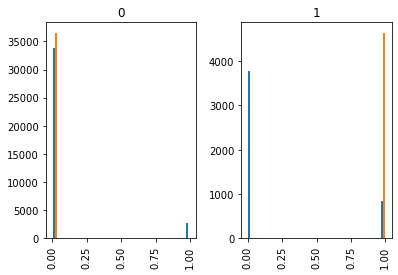

job_admin.


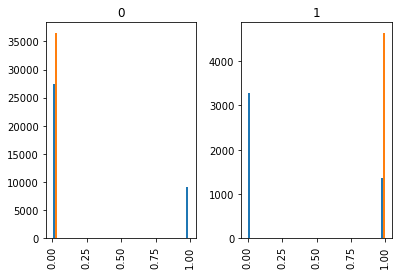

job_blue-collar


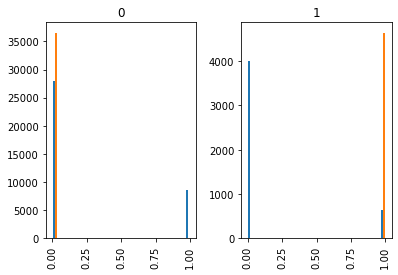

job_entrepreneur


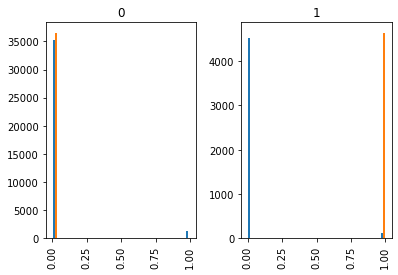

job_housemaid


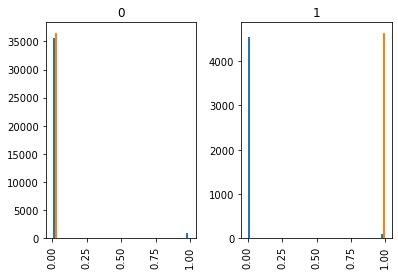

job_management


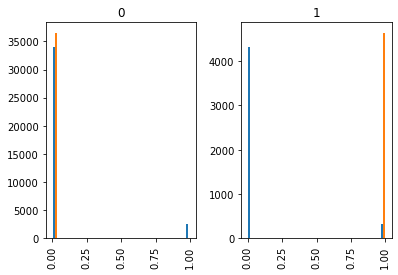

job_retired


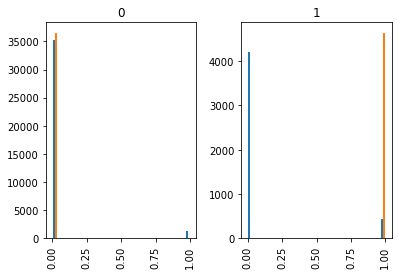

job_self-employed


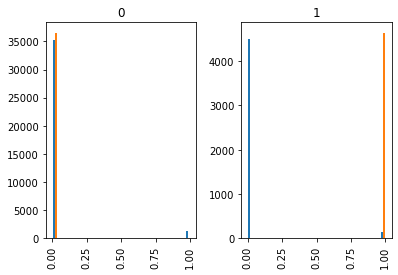

job_services


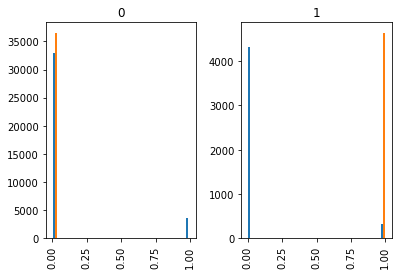

job_student


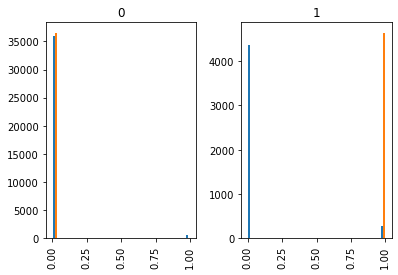

job_technician


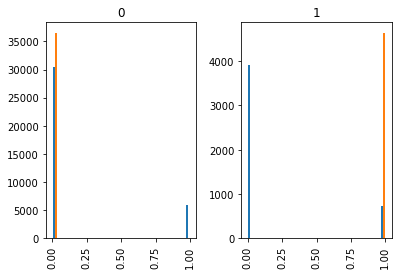

job_unemployed


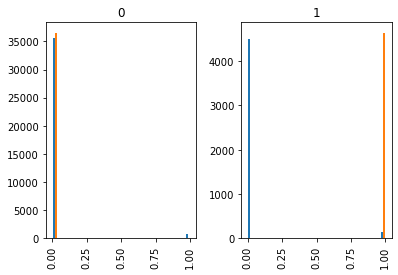

job_unknown


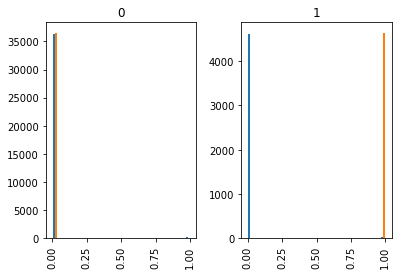

marital_divorced


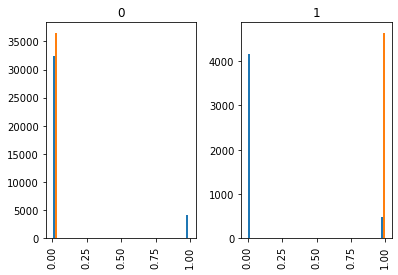

marital_married


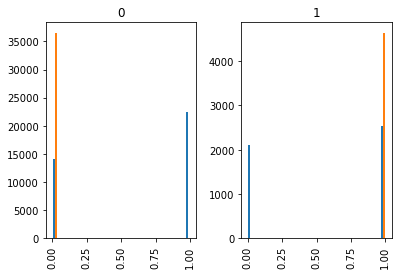

marital_single


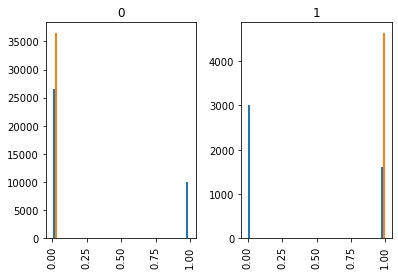

marital_unknown


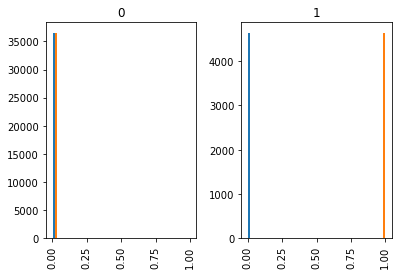

education_basic.4y


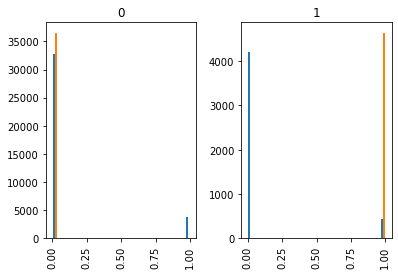

education_basic.6y


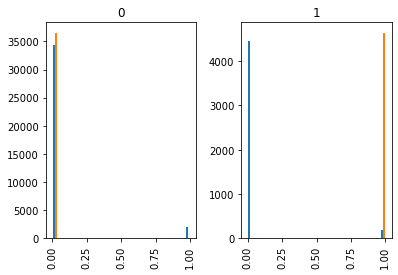

education_basic.9y


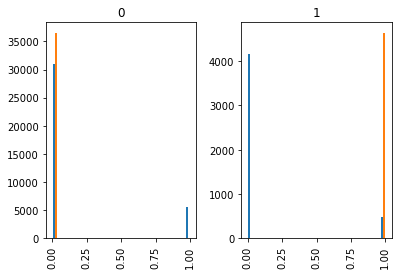

education_high.school


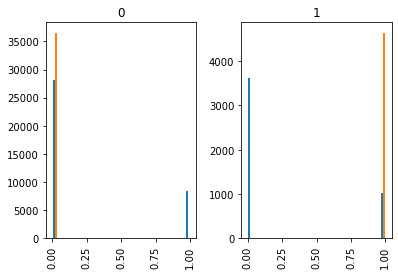

education_illiterate


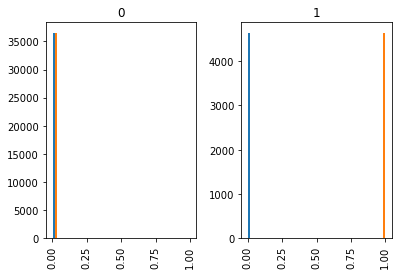

education_professional.course


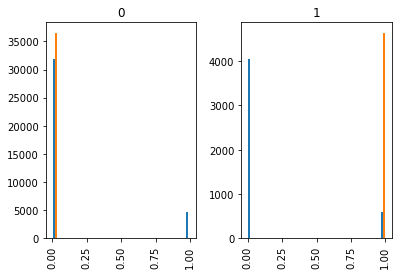

education_university.degree


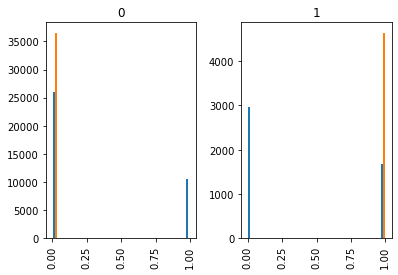

education_unknown


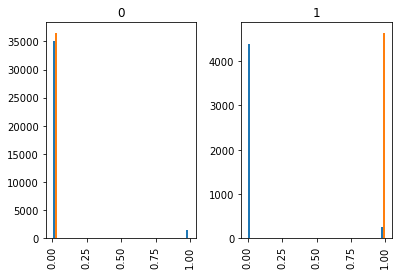

default_no


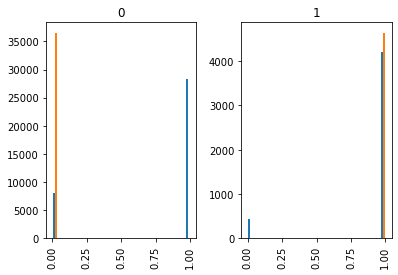

default_unknown


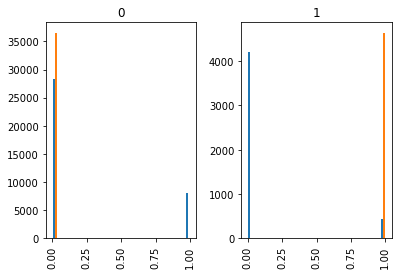

default_yes


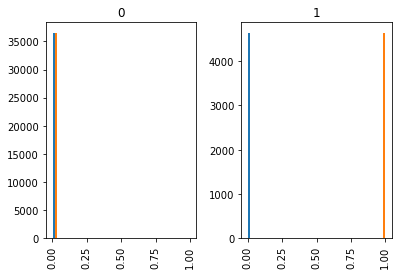

housing_no


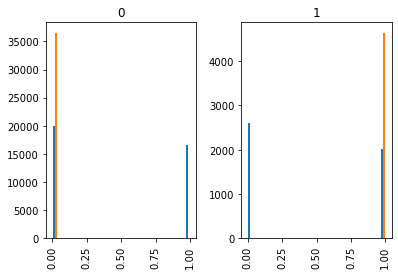

housing_unknown


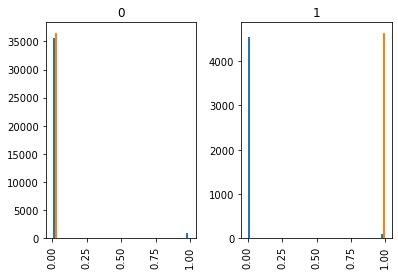

housing_yes


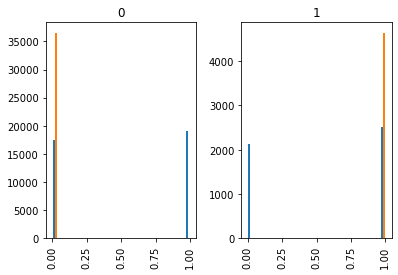

loan_no


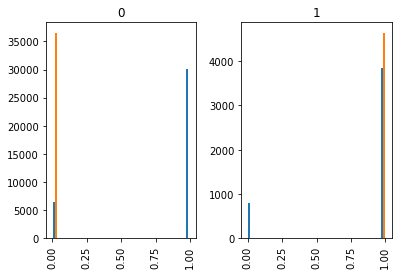

loan_unknown


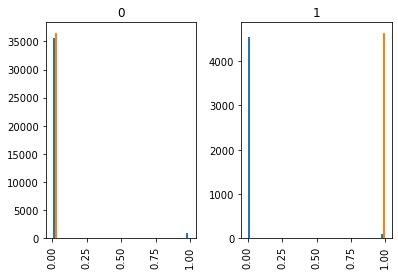

loan_yes


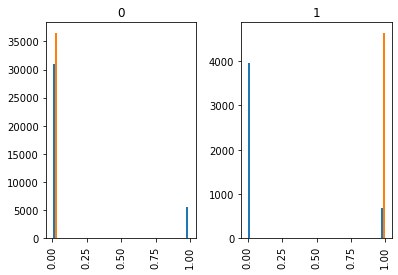

contact_cellular


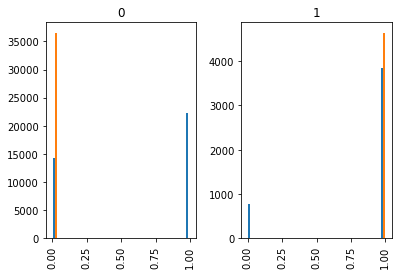

contact_telephone


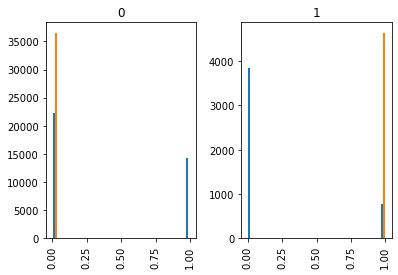

month_apr


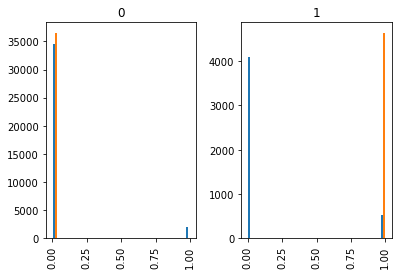

month_aug


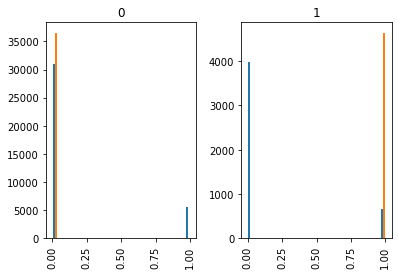

month_dec


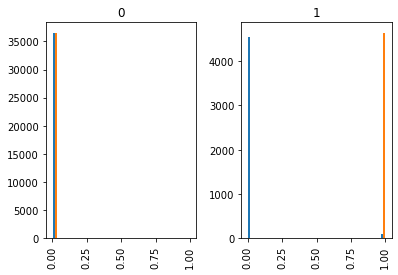

month_jul


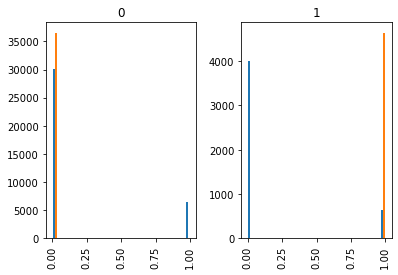

month_jun


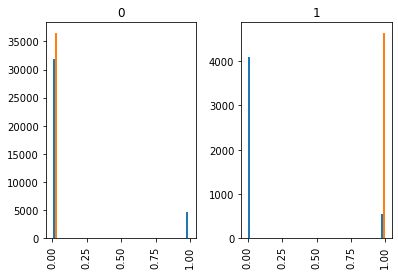

month_mar


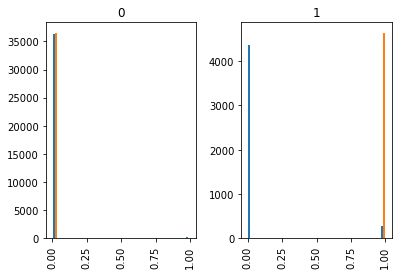

month_may


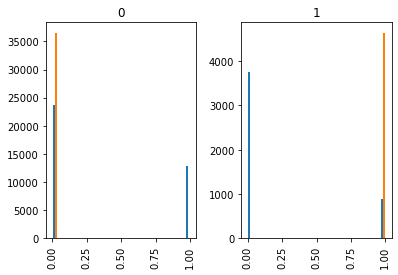

month_nov


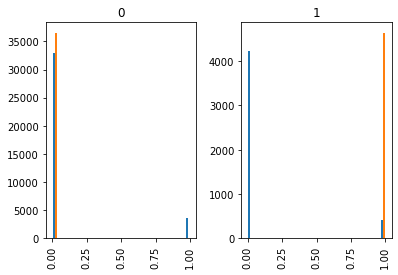

month_oct


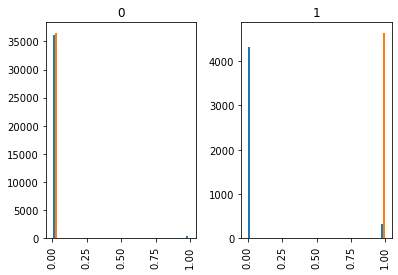

month_sep


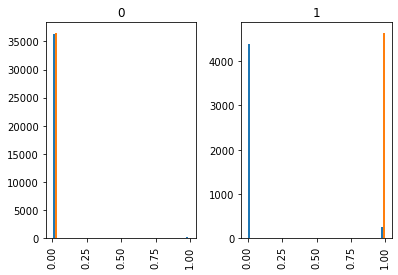

day_of_week_fri


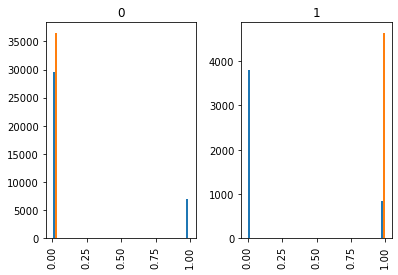

day_of_week_mon


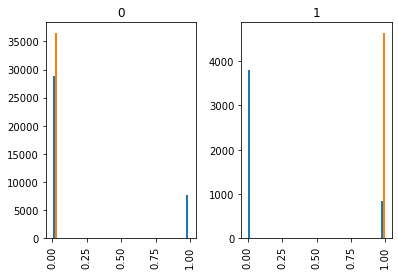

day_of_week_thu


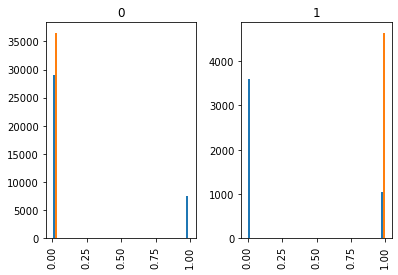

day_of_week_tue


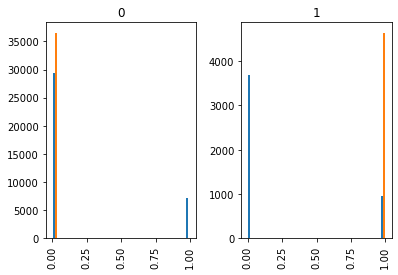

day_of_week_wed


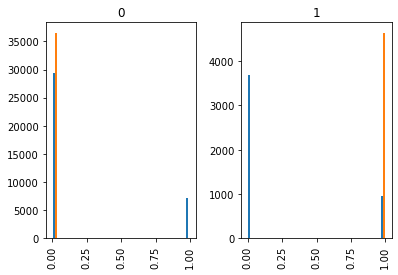

poutcome_failure


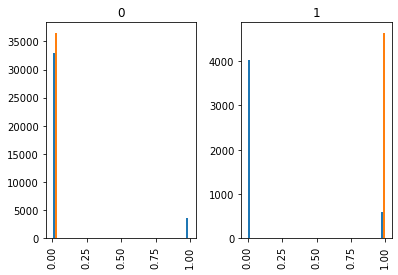

poutcome_nonexistent


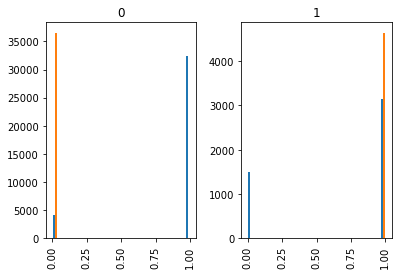

poutcome_success


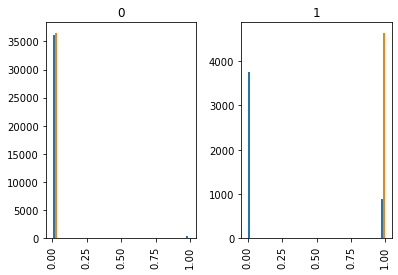

y_no


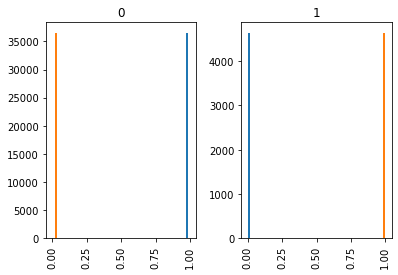

y_yes


ValueError: Grouper for 'y_yes' not 1-dimensional

In [21]:
for column in model_data.select_dtypes(include=["object"]).columns:
    if column != "y_yes":
        display(pd.crosstab(index=model_data[column], columns=model_data["y_yes"], normalize="columns"))

for column in model_data.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = model_data[[column, "y_yes"]].hist(by="y_yes", bins=30)
    plt.show()

In [5]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [6]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')


In [7]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[my_region],
                                    role, 
                                    instance_count=2, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
                                    sagemaker_session=sess)
                                    
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [8]:
xgb.fit({'train': s3_input_train})

2022-06-26 16:44:22 Starting - Starting the training job...
2022-06-26 16:44:48 Starting - Preparing the instances for trainingProfilerReport-1656261862: InProgress
............
2022-06-26 16:46:41 Downloading - Downloading input data...
2022-06-26 16:47:21 Training - Downloading the training image......
2022-06-26 16:48:21 Training - Training image download completed. Training in progress.Arguments: train
[2022-06-26:16:48:12:INFO] Running distributed xgboost training.
[2022-06-26:16:48:12:INFO] Number of hosts: 2, master IP address: 10.2.207.231, host IP address: 10.2.207.231.
[2022-06-26:16:48:12:INFO] Finished Yarn configuration files setup.
Arguments: train
[2022-06-26:16:48:13:INFO] Running distributed xgboost training.
[2022-06-26:16:48:13:INFO] Number of hosts: 2, master IP address: 10.2.207.231, host IP address: 10.2.230.152.
[2022-06-26:16:48:13:INFO] Finished Yarn configuration files setup.
starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-ip-10-2-230-15

In [9]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---------!

In [10]:
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
#xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


In [11]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Observed
No Purchase    90% (10770)    36% (166)
Purchase        10% (1132)     64% (289) 



In [12]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[{'ResponseMetadata': {'RequestId': 'GNZMPRCV22TVBR2N',
   'HostId': 'Rt/Rs562B7Up5M7YVsXBdiqKMlSGTuZkK+6hh26MXos2ZQXvmLhPrTdJaAqlwueBg7UB/2HS31I=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'Rt/Rs562B7Up5M7YVsXBdiqKMlSGTuZkK+6hh26MXos2ZQXvmLhPrTdJaAqlwueBg7UB/2HS31I=',
    'x-amz-request-id': 'GNZMPRCV22TVBR2N',
    'date': 'Sun, 26 Jun 2022 16:55:15 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-06-26-16-44-22-150/profiler-output/framework/training_job_end.ts'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-06-26-16-44-22-150/rule-output/ProfilerReport-1656261862/profiler-output/profiler-reports/IOBottleneck.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-06-26-16-44-22-150/profiler-output/system/incremental/2022062616/1656262080.algo-1.json'},
   {'Key': 'sag